## Cenário III

O Problema do Caixeiro Viajante (Traveling Salesperson - TSP) é um dos mais famosos problemas de otimização combinatória. Este problema é muito fácil de explicar, mas muito complicado de resolver - mesmo para casos com um pequeno número de cidades.

A origem do problema do caixeiro viajante não é muito clara; ele chega a ser mencionado em um manual de 1832 para caixeiros-viajantes, que incluía exemplos de passeios por 45 cidades alemãs, mas não foi formulado originalmente como um problema matemático. No entanto, em 1800, os matemáticos William Rowan Hamilton e Thomas Kirkman criaram formulações matemáticas do problema.

O TSP pode ser definido da seguinte forma: para uma determinada lista de cidades e as distâncias entre cada par delas, queremos encontrar a rota mais curta possível, que vai a cada cidade uma vez e retorna à cidade de origem.

Existe uma classe de Problemas de Pessoa Caixeira Viajante que assume que a distância de ir da cidade $ i $ à cidade $ j $ é a mesma que ir da cidade $ j $ à cidade $ i $, este tipo de TSP também é conhecido como TSP simétrico. Para o seguinte cenário sugerimos usar distâncias euclidianas, mas a formulação do modelo TSP é válida independentemente da forma como as distâncias individuais são determinadas.

A programação matemática é uma abordagem declarativa em que o modelador formula um modelo de otimização matemática que captura os principais aspectos de um problema de decisão complexo. 

Um modelo de otimização matemática tipicamente vai possuir cinco componentes, a saber:

* Conjuntos e índices;
* Parâmetros;
* Variáveis ​​de decisão;
* Função (ões) objetivo (s);
* Quaisquer restrições.

Como entregável, a indústria necessita de uma formulação de TSP que identifique a rota mais curta para as capitais brasileiras, que vai a todas as cidades uma vez e retorna à cidade de origem (os arquivos a serem utilizados, contendo os dados das capitais brasileiras a serem utilizados nesse cenário, você encontra <a href="https://drive.google.com/drive/folders/1pip1P29vKGYWUOSD0hVrdNLNQcGzG3eN?usp=sharing">aqui</a>)

* states_coords.csv: contém a latitude e longitude de cada capital de estado brasileiro;
* states_line.json: contém o nome dos estados e a distância em km de todos os pares possíveis assumindo uma linha conectando as cidades;
* states_gmaps.json: contém o nome dos estados e a distância em km de todos os pares possíveis com as informações do Google a respeito.

In [1]:
import pandas as pd
import numpy as np
import json
from py2opt.routefinder import RouteFinder
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
np.random.seed(0)

### Dados

In [2]:
# Estados e as coordenadas geográficas de suas capitais
df_coords = pd.read_csv('dados/states_coords.csv').sort_values('estado')

# Distancia entre as capitais
with open('dados/states_line.json', 'r', encoding='utf-8') as read_file:
   json_lines = json.load(read_file)
df_lines = pd.DataFrame.from_dict(json_lines['edges'])
df_lines.columns = ['origem', 'destino', 'distancia']

In [3]:
df_coords.head(3)

,estado,lat,lng
23,Acre,-9.9666,-67.80
12,Alagoas,-9.6200,-35.73
21,Amapá,0.0330,-51.05


In [4]:
df_lines.head(3)

,origem,destino,distancia
0,São Paulo,Rio de Janeiro,354.557321
1,São Paulo,Minas Gerais,492.561745
2,São Paulo,Rio Grande do Sul,852.763702


In [5]:
# Cria matriz de distâncias
df_dists = pd.pivot_table(df_lines, values='distancia', index='origem',
                          columns='destino', aggfunc='mean', fill_value=0)

In [6]:
df_dists.head(5)

destino,Acre,Alagoas,Amapá,Amazonas,Bahia,Ceará,Espírito Santo,Goiás,Maranhão,Mato Grosso,...,Piauí,Rio Grande do Norte,Rio Grande do Sul,Rio de Janeiro,Rondônia,Roraima,Santa Catarina,Sergipe,São Paulo,Tocantins
origem,,,,,,,,,,,,,,,,,,,,,
Acre,0.000000,3513.996165,2161.731596,1151.250836,3211.740924,3298.009998,3156.357940,2136.767119,2728.920359,1414.802440,...,2810.436445,3615.830865,2820.369451,2984.087454,448.894586,1626.696773,2812.967855,3356.322632,2708.559270,2136.580466
Alagoas,3513.996165,0.000000,2007.290817,2777.525074,478.320857,724.805607,1290.275506,1667.307214,1230.681203,2304.941128,...,926.186791,430.522631,2782.668061,1681.333702,3093.837618,3090.043502,2405.811639,208.362772,1934.896693,1377.506567
Amapá,2161.731596,2007.290817,0.000000,1054.284615,2003.288949,1448.514513,2545.495901,1873.284233,805.866298,1821.475487,...,1081.333768,1870.841796,3346.164787,2690.286145,1726.674075,1113.063359,3083.247980,1962.274032,2667.276248,1182.577161
Amazonas,1151.250836,2777.525074,1054.284615,0.000000,2608.996578,2379.323128,2863.964523,1913.740172,1749.174539,1451.755942,...,1923.191472,2761.535697,3137.700120,2850.957201,762.210686,662.199676,2983.591911,2668.637083,2692.100335,1517.313663
Bahia,3211.740924,478.320857,2003.288949,2608.996578,0.000000,1025.597970,842.272708,1235.509731,1325.733550,1919.039306,...,994.988807,875.121958,2306.960107,1215.465687,2814.714210,3014.187439,1931.183948,273.706227,1457.532585,1110.838548


In [7]:
# Se os índices dos dataframes de coordenadas e da matriz de distâncias não estiverem na mesma ordem
# Interrompe a execução do script
if not((df_coords['estado'] == df_dists.index).all()):
    raise SystemExit('Erro: os indices não estão na mesma ordem!')

# Converte os dataframes em arrays numpy (para se trabalhar com índices numéricos)
df_coords = df_coords.to_numpy()
df_dists = df_dists.to_numpy()

### Algoritmo 2-opt

In [8]:
states_names = np.arange(df_coords.shape[0]).tolist()
route_finder = RouteFinder(df_dists, states_names, iterations=250)
best_dist_2opt, best_route_2opt = route_finder.solve()

print(best_dist_2opt)
print(best_route_2opt)
route_2opt = [df_coords[i, 0] for i in best_route_2opt]
print(route_2opt)

0 msec
4 msec
6 msec
8 msec
11 msec
12 msec
15 msec
17 msec
19 msec
21 msec
23 msec
25 msec
26 msec
29 msec
31 msec
33 msec
36 msec
39 msec
41 msec
43 msec
45 msec
47 msec
49 msec
51 msec
53 msec
55 msec
57 msec
59 msec
61 msec
63 msec
65 msec
66 msec
68 msec
70 msec
72 msec
75 msec
88 msec
94 msec
97 msec
101 msec
104 msec
109 msec
114 msec
121 msec
124 msec
127 msec
132 msec
139 msec
142 msec
145 msec
147 msec
150 msec
154 msec
156 msec
159 msec
162 msec
164 msec
166 msec
169 msec
173 msec
175 msec
177 msec
179 msec
181 msec
182 msec
184 msec
186 msec
188 msec
190 msec
192 msec
193 msec
195 msec
197 msec
199 msec
200 msec
203 msec
205 msec
207 msec
209 msec
210 msec
212 msec
214 msec
217 msec
218 msec
220 msec
223 msec
225 msec
227 msec
229 msec
231 msec
234 msec
235 msec
237 msec
240 msec
243 msec
245 msec
247 msec
249 msec
251 msec
253 msec
255 msec
258 msec
259 msec
262 msec
263 msec
266 msec
268 msec
270 msec
272 msec
274 msec
275 msec
277 msec
279 msec
281 msec
283 msec
285 msec

### Função objetivo

Objetivo: A partir de um ponto qualquer, percorrer todos os pontos uma única vez, e voltar para o ponto de origem
de forma que a soma das distâncias percorridas seja a menor possível.

In [9]:
qtd_pontos = df_coords.shape[0]
print('Qtd de pontos:', qtd_pontos)

Qtd de pontos: 26


In [10]:
# A solução (ciclo hamiltoniano) pode ser representada por meio de uma permutação
# Como se trata de um ciclo, o ponto de partida pode ser travado, sendo representado pelo ponto zero
s1 = np.arange(1, qtd_pontos, dtype=int)
print('Exemplo de solução:', s1)
qtd_pontos = qtd_pontos-1

Exemplo de solução: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


In [11]:
# Retorna a distância
def get_dist(idx0, idx1):
    return df_dists[idx0][idx1]

In [12]:
def get_fitness(ind):
    fitness = get_dist(0, ind[0])                       # Distância a partir do ponto inicial (zero)
    for i in range(1, qtd_pontos):          
        fitness = fitness + get_dist(ind[i-1], ind[i])  # Distância entre pontos
    fitness = fitness + get_dist(ind[-1], 0)            # Distância entre o último e o ponto inicial
    return fitness

In [13]:
print('Distância total da solução exemplo:', round(get_fitness(s1), 2)) # 46371.48

Distância total da solução exemplo: 46371.48


### Algoritmo genético v1

In [14]:
def get_ind_greed(tx_greed=0.7):
    idx = np.random.permutation(s1) # Permutação aleatória
    ind = [idx[0]]
    idx = np.delete(idx, 0)
    while idx.shape[0] > 0:
        last_idx = ind[-1]
        if np.random.random() <= tx_greed:
            best_idx = 0
            best_dist = get_dist(last_idx, idx[best_idx])
            for i in range(1, idx.shape[0]):
                dist = get_dist(last_idx, idx[i])
                if dist < best_dist:
                    best_idx = i
                    best_dist = dist
        else:
            best_idx = np.random.randint(idx.shape[0])
        ind.append(idx[best_idx])
        idx = np.delete(idx, best_idx)
    ind = np.array(ind)
    dist = get_fitness(ind)
    return ind, dist

In [15]:
def get_mut_swap1(gen):   # Operador de mutação: Troca dois números aleatórios
    rnd_idx = np.random.choice(qtd_pontos, 2)
    gen[rnd_idx[0]], gen[rnd_idx[1]] = gen[rnd_idx[1]], gen[rnd_idx[0]]
    return gen, get_fitness(gen)

In [16]:
def get_mut_swap2(gen):   # Operador de mutação: Troca dois números consecutivos
    rnd_idx = np.random.randint(qtd_pontos - 1)
    gen[rnd_idx], gen[rnd_idx + 1] = gen[rnd_idx + 1], gen[rnd_idx]
    return gen, get_fitness(gen)

In [17]:
def get_mut_reverse(gen):   # Operador de mutação: Inverte pedaço do gene
    rnd_idx = np.random.choice(qtd_pontos, 2)
    idx_ini, idx_fim = min(rnd_idx), max(rnd_idx)
    gen[idx_ini:idx_fim] = np.flip(gen[idx_ini:idx_fim])
    return gen, get_fitness(gen)

In [18]:
def order_crossover(gen1, gen2):
    rnd_idx = np.random.choice(qtd_pontos, 2)
    idx_ini, idx_fim = min(rnd_idx), max(rnd_idx)
    filho = np.zeros(qtd_pontos, dtype=int)
    filho[idx_ini:idx_fim] = gen1[idx_ini:idx_fim]
    gen2_sem_gen1 = [i for i in gen2 if i not in gen1[idx_ini:idx_fim]]
    filho[:idx_ini] = gen2_sem_gen1[:idx_ini]
    filho[idx_fim:] = gen2_sem_gen1[idx_ini:]
    return filho, get_fitness(filho)

In [19]:
# Cria uma população
tam_pop = 10    # Tamanho da população
tx_greed = 0.7  # Taxa de ganância
pop = []        # Armazena a genótipo
fit = []        # Armazena distância do ciclo de cada indivíduo
for i in range(0, tam_pop):
    #ind = np.random.permutation(s1)
    #dist = get_fitness(ind) # Permutação aleatória
    ind, dist = get_ind_greed(tx_greed)  # Algoritmo guloso na maior parte do tempo
    pop.append(ind)
    fit.append(dist)

print('População:')
print('Tamanho:', tam_pop, 'Média:', round(np.mean(fit), 3), 'Melhor:', round(np.min(fit), 3))

População:
Tamanho: 10 Média: 29192.512 Melhor: 23895.951


In [20]:
qtd_iter = 100000                               # Qtd de gerações
tx_cruz = 0.99                                  # Taxa de cruzamento
tx_mut1, tx_mut2, tx_mut3 = 0.1, 0.1, 0.8      # Taxas de mutação
tx_rnd = 0.1                                    # Taxa de elitismo (quanto menor, mais elitista)
tx_greed = 0.5                                  # Taxa de ganância de novos indivíduos

idx_melhor_ind = np.argmin(fit)
fit_melhor_ind = fit[idx_melhor_ind]
melhor_ind = pop[idx_melhor_ind]
print('Melhor indivídio:', fit_melhor_ind)

for iter in range(qtd_iter):
    # Seleção por torneio
    rnd_inds = np.random.choice(tam_pop, 4)
    idx_0 = rnd_inds[0] if fit[rnd_inds[0]] < fit[rnd_inds[1]] else rnd_inds[1]
    idx_1 = rnd_inds[2] if fit[rnd_inds[2]] < fit[rnd_inds[3]] else rnd_inds[3]
    
    # Efetua cruzamento ou seleciona o melhor indivíduo do torneio
    if np.random.random() <= tx_cruz:
        pai_0, pai_1 = pop[idx_0], pop[idx_1]
        ind_filho, ind_filho_fit = order_crossover(pai_0, pai_1)
    else:
        idx_melhor = idx_0 if fit[idx_0] < fit[idx_1] else idx_1
        ind_filho, ind_filho_fit = pop[idx_melhor], fit[idx_melhor]

    # Mutação
    if np.random.random() <= tx_mut1:
        ind_filho, ind_filho_fit = get_mut_swap1(ind_filho)
    if np.random.random() <= tx_mut2:
        ind_filho, ind_filho_fit = get_mut_swap2(ind_filho)
    if np.random.random() <= tx_mut3:
        ind_filho, ind_filho_fit = get_mut_reverse(ind_filho)
    
    # Filho substitui o pior pai se for melhor, ou se passar na taxa de aceitação
    idx_pior = idx_0 if fit[idx_0] > fit[idx_1] else idx_1
    if (ind_filho_fit < fit[idx_pior]) or (np.random.random() < tx_rnd):
        pop[idx_pior], fit[idx_pior] = ind_filho, ind_filho_fit

    # Se o desvio padrão da população está muito baixo
    # Substitui um indivíduo qualquer da população por um novo
    if np.std(fit) < 5000:
        rnd_ind = np.random.randint(tam_pop)
        ind_filho, ind_filho_fit = get_ind_greed(tx_greed)
        pop[rnd_ind], fit[rnd_ind] = ind_filho, ind_filho_fit

    # Armazena melhor indivíduo
    idx_melhor_ind = np.argmin(fit)
    if fit[idx_melhor_ind] < fit_melhor_ind:
        fit_melhor_ind = fit[idx_melhor_ind]
        melhor_ind = pop[idx_melhor_ind]
    
    if iter % 10000 == 0:
        print('Iter:', iter, 
              '| Média:', round(np.mean(fit), 3), 
              '| Desvio:', round(np.std(fit), 3), 
              '| Melhor pop:', round(np.min(fit), 3),
              '| Melhor global:', round(fit_melhor_ind, 3))

print('Melhor Indivíduo:', fit_melhor_ind)

Melhor indivídio: 23895.951073862347
Iter: 0 | Média: 29854.943 | Desvio: 3754.377 | Melhor pop: 23895.951 | Melhor global: 23895.951
Iter: 10000 | Média: 20719.074 | Desvio: 8660.645 | Melhor pop: 14566.292 | Melhor global: 13920.978
Iter: 20000 | Média: 22619.142 | Desvio: 7884.289 | Melhor pop: 17487.347 | Melhor global: 13808.12
Iter: 30000 | Média: 18241.599 | Desvio: 5069.556 | Melhor pop: 15301.228 | Melhor global: 13808.12
Iter: 40000 | Média: 20748.856 | Desvio: 5576.795 | Melhor pop: 16794.818 | Melhor global: 13808.12
Iter: 50000 | Média: 17030.317 | Desvio: 5535.555 | Melhor pop: 14467.837 | Melhor global: 13808.12
Iter: 60000 | Média: 18802.391 | Desvio: 6471.444 | Melhor pop: 14393.306 | Melhor global: 13717.636
Iter: 70000 | Média: 23198.996 | Desvio: 5632.859 | Melhor pop: 14854.943 | Melhor global: 13717.636
Iter: 80000 | Média: 19797.323 | Desvio: 5945.487 | Melhor pop: 14809.735 | Melhor global: 13717.636
Iter: 90000 | Média: 18550.772 | Desvio: 5705.98 | Melhor pop:

### Resultados

In [21]:
def show_route(route_idx):
    fig = plt.figure(figsize=(14, 10))
    m = Basemap(projection='merc', llcrnrlat=-35, urcrnrlat=7, llcrnrlon=-77, urcrnrlon=-32, resolution='i')
    m.bluemarble()
    #m.fillcontinents(color='tan', lake_color='lightblue')
    #m.drawmapboundary(fill_color='lightblue')
    
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
    m.drawstates(linewidth=0.5, linestyle='solid', color='k')

    for i in range(df_coords.shape[0]):
        m.plot(df_coords[i, 2], df_coords[i, 1], marker='o', c='r', markersize=10, zorder=10, alpha=0.8, latlon=True)

    lons = [df_coords[i, 2] for i in route_idx]
    lons.append(lons[0])
    lats = [df_coords[i, 1] for i in route_idx]
    lats.append(lats[0])
    x, y = m(lons, lats)
    m.plot(x, y, marker=None, color='b')

    plt.show()

#### 2-OPT

Melhor rota do 2-opt: 12028.65
['Acre', 'Rondônia', 'Amazonas', 'Roraima', 'Amapá', 'Pará', 'Maranhão', 'Piauí', 'Ceará', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Bahia', 'Espírito Santo', 'Minas Gerais', 'Rio de Janeiro', 'São Paulo', 'Paraná', 'Santa Catarina', 'Rio Grande do Sul', 'Mato Grosso do Sul', 'Mato Grosso', 'Goiás', 'Tocantins']


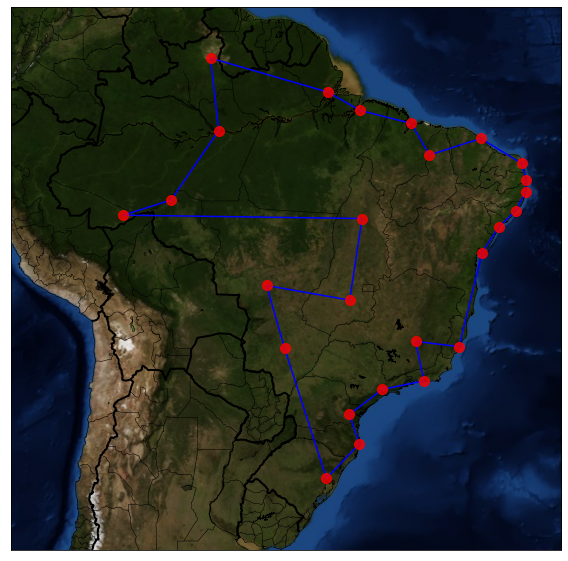

In [22]:
print('Melhor rota do 2-opt:', best_dist_2opt)
print(route_2opt)
show_route(best_route_2opt)

#### Algoritmo genético

Melhor rota do algoritmo genético: 13717.63623731026
['Acre', 'Mato Grosso', 'Mato Grosso do Sul', 'Rio Grande do Sul', 'Santa Catarina', 'Paraná', 'São Paulo', 'Rio de Janeiro', 'Espírito Santo', 'Minas Gerais', 'Goiás', 'Tocantins', 'Bahia', 'Sergipe', 'Alagoas', 'Pernambuco', 'Paraíba', 'Rio Grande do Norte', 'Ceará', 'Piauí', 'Maranhão', 'Pará', 'Amapá', 'Roraima', 'Amazonas', 'Rondônia']


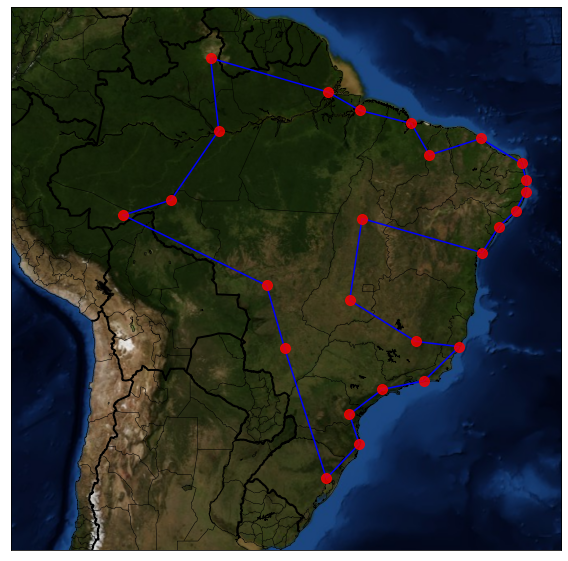

In [23]:
print('Melhor rota do algoritmo genético:', fit_melhor_ind)
melhor_ind = np.insert(melhor_ind, 0, 0)
route_ga = [df_coords[i][0] for i in melhor_ind]
print(route_ga)
show_route(melhor_ind)